**Autoencoder Photo to Sketch**

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import os
import re
import random
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPool2D, Dropout, Input, LeakyReLU
from keras.preprocessing.image import img_to_array
from keras import Model
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Define the root directory
ROOT_DIR = '/content/drive/My Drive/'

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

# Move the uploaded file to the required location
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# code colab
# !kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs /content/drive/MyDrive/kaggle_datasets

In [ ]:
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs -p /content/drive/MyDrive/kaggle_datasets

 90% 102M/113M [00:00<00:00, 199MB/s] 
100% 113M/113M [00:00<00:00, 202MB/s]


In [ ]:
# code colab
# !unzip /content/cuhk-face-sketch-database-cufs.zip

In [ ]:
import zipfile
import os

# Path to the downloaded zip file
zip_file_path = "/content/drive/MyDrive/kaggle_datasets/cuhk-face-sketch-database-cufs.zip"

# Directory where you want to extract the files
extract_dir = "/content/drive/MyDrive/kaggle_datasets/"

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the files in the extraction directory to verify
os.listdir(extract_dir)

['cuhk-face-sketch-database-cufs.zip',
 'cropped_sketch',
 'original_sketch',
 'photo',
 'photo_points',
 'photos',
 'sketch',
 'sketch_points',
 'sketches']

In [ ]:
image_path = '/content/drive/MyDrive/kaggle_datasets/photos'
sketch_path = '/content/drive/MyDrive/kaggle_datasets/sketches'

image_array = []
sketch_array = []

IMAGE_SIZE = 224

In [ ]:
import os

def sort_image(data):
    def alphanum_key(key):
        convert = lambda text: int(text) if text.isdigit() else text.lower()
        return [convert(c) for c in re.split('([0-9]+)', key)]

    return sorted(data, key=alphanum_key)

image_files = sort_image([os.path.join(image_path, f) for f in os.listdir(image_path)])
sketch_files = sort_image([os.path.join(sketch_path, f) for f in os.listdir(sketch_path)])

In [ ]:
from tqdm import tqdm
import cv2
import numpy as np

def process_and_augment_images(image_files, data_array):
    def augment_image(image):
        return [image,
                cv2.flip(image, 1),
                cv2.flip(image, -1),
                cv2.flip(cv2.flip(image, 1), 0),
                cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE),
                cv2.flip(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE), 1),
                cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE),
                cv2.flip(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE), 1)]

    for file in tqdm(image_files):
        image = cv2.imread(file, 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = image.astype('float32') / 255.0

        data_array.extend([np.array(augmented_image) for augmented_image in augment_image(image)])

# Assuming IMAGE_SIZE is defined somewhere in your code
IMAGE_SIZE = 224

image_array = []
sketch_array = []

process_and_augment_images(image_files, image_array)
process_and_augment_images(sketch_files, sketch_array)

print(f'\nNumber of augmented images: {len(image_array)}')
print(f'Number of augmented sketches: {len(sketch_array)}')

100%|██████████| 188/188 [00:02<00:00, 81.30it/s]


Number of augmented images: 1504
Number of augmented sketches: 1504


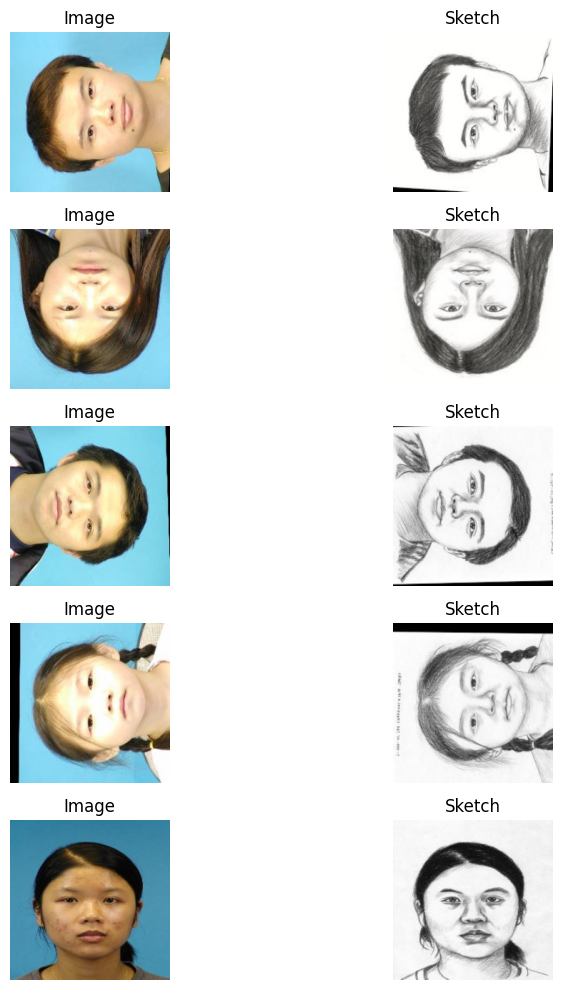

In [ ]:
import matplotlib.pyplot as plt
import random

def visualize_images_and_sketches(images, sketches, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))

    for i in range(num_samples):
        idx = random.randint(0, len(images) - 1)

        axes[i, 0].imshow(images[idx])
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(sketches[idx], cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Sketch')

    plt.tight_layout()
    plt.show()

# Assuming you have image_array and sketch_array
num_samples = 5
visualize_images_and_sketches(image_array, sketch_array, num_samples)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert sketch_array and image_array to numpy arrays
sketch_array_np = np.array(sketch_array)
image_array_np = np.array(image_array)

# Split the dataset into train and test sets
train_sketch_image, test_sketch_image, train_image, test_image = train_test_split(
    sketch_array_np, image_array_np, test_size=0.2, random_state=42
)

# Reshape the train and test sets
def reshape_images(images):
    return images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)

train_sketch_image = reshape_images(train_sketch_image)
train_image = reshape_images(train_image)
test_sketch_image = reshape_images(test_sketch_image)
test_image = reshape_images(test_image)

# Print the shapes of the train and test sets
print('Train image shape:', train_image.shape)
print('Test image shape:', test_image.shape)

Train image shape: (1203, 224, 224, 3)
Test image shape: (301, 224, 224, 3)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout
import tensorflow.keras as keras

def build_encoder_decoder(encoder_input):
    # Encoder
    x = Conv2D(filters=16, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(encoder_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.1)(x)

    x = Conv2D(filters=64, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.1)(x)

    x = Conv2D(filters=128, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.1)(x)

    x = Conv2D(filters=256, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.1)(x)

    x = Conv2D(filters=512, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    encoder_output = LeakyReLU()(x)

    # Decoder
    x = Conv2DTranspose(filters=512, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(encoder_output)
    x = Dropout(0.1)(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=512, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
    x = Dropout(0.1)(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
    x = Dropout(0.1)(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=32, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
    x = Dropout(0.1)(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=16, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
    x = Dropout(0.1)(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=8, kernel_size=(2, 2), strides=(1, 1), padding='valid')(x)
    x = Dropout(0.1)(x)
    x = LeakyReLU()(x)

    decoder_output = Conv2DTranspose(filters=3, kernel_size=(2, 2), strides=(1, 1), padding='valid')(x)

    return encoder_output, decoder_output

encoder_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
encoder_output, decoder_output = build_encoder_decoder(encoder_input)

model = Model(encoder_input, decoder_output)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['acc'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 111, 111, 16)      768       
                                                                 
 batch_normalization (Batch  (None, 111, 111, 16)      64        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 111, 111, 16)      0         
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 64)        16384     
                                                             

In [ ]:
model.fit(train_image, train_sketch_image, epochs = 100, batch_size=16)

Epoch 1/100
76/76 [==============================] - 23s 136ms/step - loss: 0.3075 - acc: 0.3452
Epoch 2/100
76/76 [==============================] - 9s 113ms/step - loss: 0.1720 - acc: 0.3055
Epoch 3/100
76/76 [==============================] - 9s 112ms/step - loss: 0.1509 - acc: 0.2938
Epoch 4/100
76/76 [==============================] - 9s 113ms/step - loss: 0.1389 - acc: 0.2913
Epoch 5/100
76/76 [==============================] - 9s 114ms/step - loss: 0.1299 - acc: 0.2915
Epoch 6/100
76/76 [==============================] - 9s 114ms/step - loss: 0.1210 - acc: 0.3020
Epoch 7/100
76/76 [==============================] - 9s 116ms/step - loss: 0.1153 - acc: 0.3256
Epoch 8/100
76/76 [==============================] - 9s 116ms/step - loss: 0.1108 - acc: 0.3390
Epoch 9/100
76/76 [==============================] - 9s 117ms/step - loss: 0.1060 - acc: 0.3451
Epoch 10/100
76/76 [==============================] - 9s 118ms/step - loss: 0.1028 - acc: 0.3467
Epoch 11/100
76/76 [==================

In [ ]:
test_loss, test_accuracy = model.evaluate(test_image, test_sketch_image)

print("Test Loss:", test_loss)
print("Accuracy on test set:", f"{np.round(test_accuracy * 100, 2)}%")

10/10 [==============================] - 5s 238ms/step - loss: 0.0688 - acc: 0.9965
Test Loss: 0.0687636062502861
Accuracy on test set: 99.65%


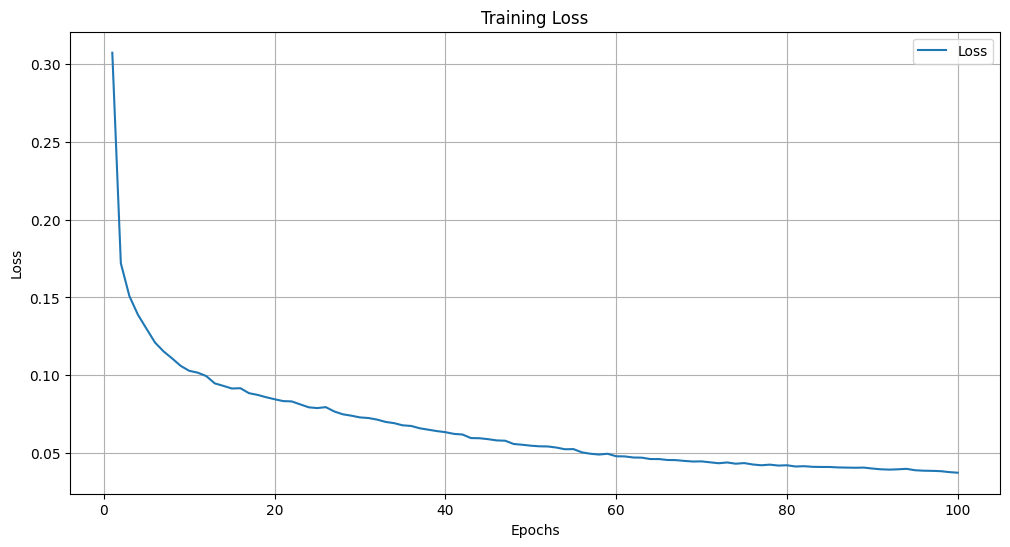

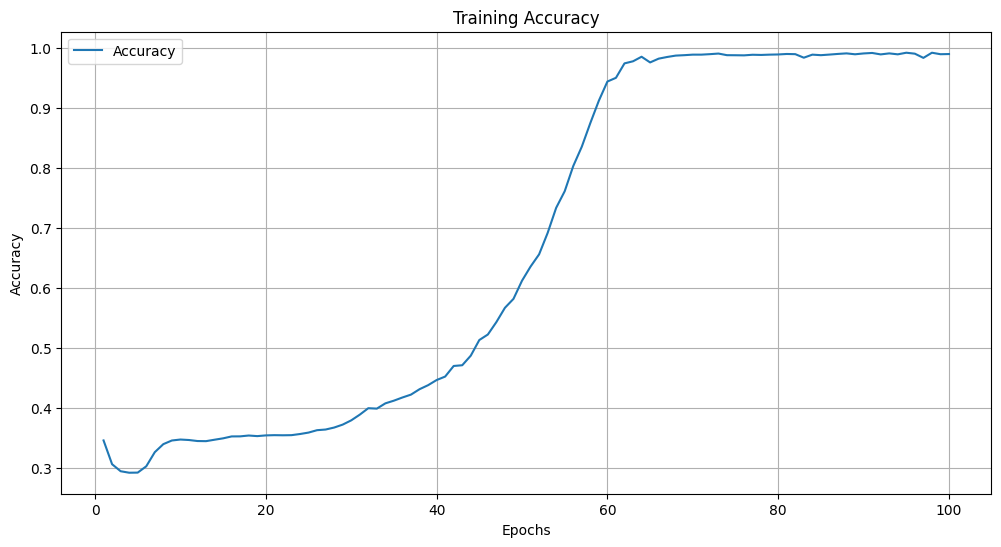

In [20]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = 100

# Define the loss and accuracy values
loss_values = [0.3075, 0.1720, 0.1509, 0.1389, 0.1299, 0.1210, 0.1153, 0.1108, 0.1060, 0.1028, 0.1016, 0.0994, 0.0947, 0.0931, 0.0914, 0.0916, 0.0884, 0.0873, 0.0858, 0.0845, 0.0833, 0.0831, 0.0812, 0.0793, 0.0788, 0.0794, 0.0766, 0.0748, 0.0739, 0.0728, 0.0724, 0.0714, 0.0699, 0.0691, 0.0677, 0.0673, 0.0658, 0.0649, 0.0640, 0.0633, 0.0622, 0.0618, 0.0595, 0.0594, 0.0588, 0.0580, 0.0578, 0.0557, 0.0552, 0.0546, 0.0542, 0.0541, 0.0534, 0.0523, 0.0524, 0.0503, 0.0494, 0.0489, 0.0494, 0.0478, 0.0477, 0.0470, 0.0469, 0.0460, 0.0460, 0.0454, 0.0453, 0.0448, 0.0444, 0.0445, 0.0439, 0.0433, 0.0438, 0.0430, 0.0434, 0.0425, 0.0420, 0.0424, 0.0418, 0.0420, 0.0412, 0.0414, 0.0410, 0.0409, 0.0409, 0.0406, 0.0405, 0.0404, 0.0405, 0.0399, 0.0394, 0.0392, 0.0394, 0.0397, 0.0388, 0.0385, 0.0384, 0.0382, 0.0376, 0.0372]
acc_values = [0.3452, 0.3055, 0.2938, 0.2913, 0.2915, 0.3020, 0.3256, 0.3390, 0.3451, 0.3467, 0.3459, 0.3442, 0.3440, 0.3464, 0.3487, 0.3519, 0.3520, 0.3534, 0.3524, 0.3536, 0.3540, 0.3538, 0.3540, 0.3559, 0.3583, 0.3623, 0.3634, 0.3667, 0.3716, 0.3787, 0.3882, 0.3990, 0.3983, 0.4071, 0.4116, 0.4169, 0.4217, 0.4307, 0.4374, 0.4460, 0.4518, 0.4695, 0.4707, 0.4867, 0.5128, 0.5220, 0.5428, 0.5666, 0.5815, 0.6118, 0.6354, 0.6558, 0.6915, 0.7335, 0.7612, 0.8032, 0.8355, 0.8750, 0.9124, 0.9443, 0.9505, 0.9746, 0.9781, 0.9857, 0.9762, 0.9825, 0.9853, 0.9876, 0.9883, 0.9892, 0.9892, 0.9900, 0.9910, 0.9883, 0.9882, 0.9880, 0.9890, 0.9887, 0.9892, 0.9895, 0.9903, 0.9900, 0.9841, 0.9892, 0.9883, 0.9893, 0.9904, 0.9913, 0.9898, 0.9912, 0.9920, 0.9896, 0.9913, 0.9897, 0.9924, 0.9908, 0.9838, 0.9924, 0.9899, 0.9902]

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), loss_values, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), acc_values, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


10/10 [==============================] - 1s 72ms/step


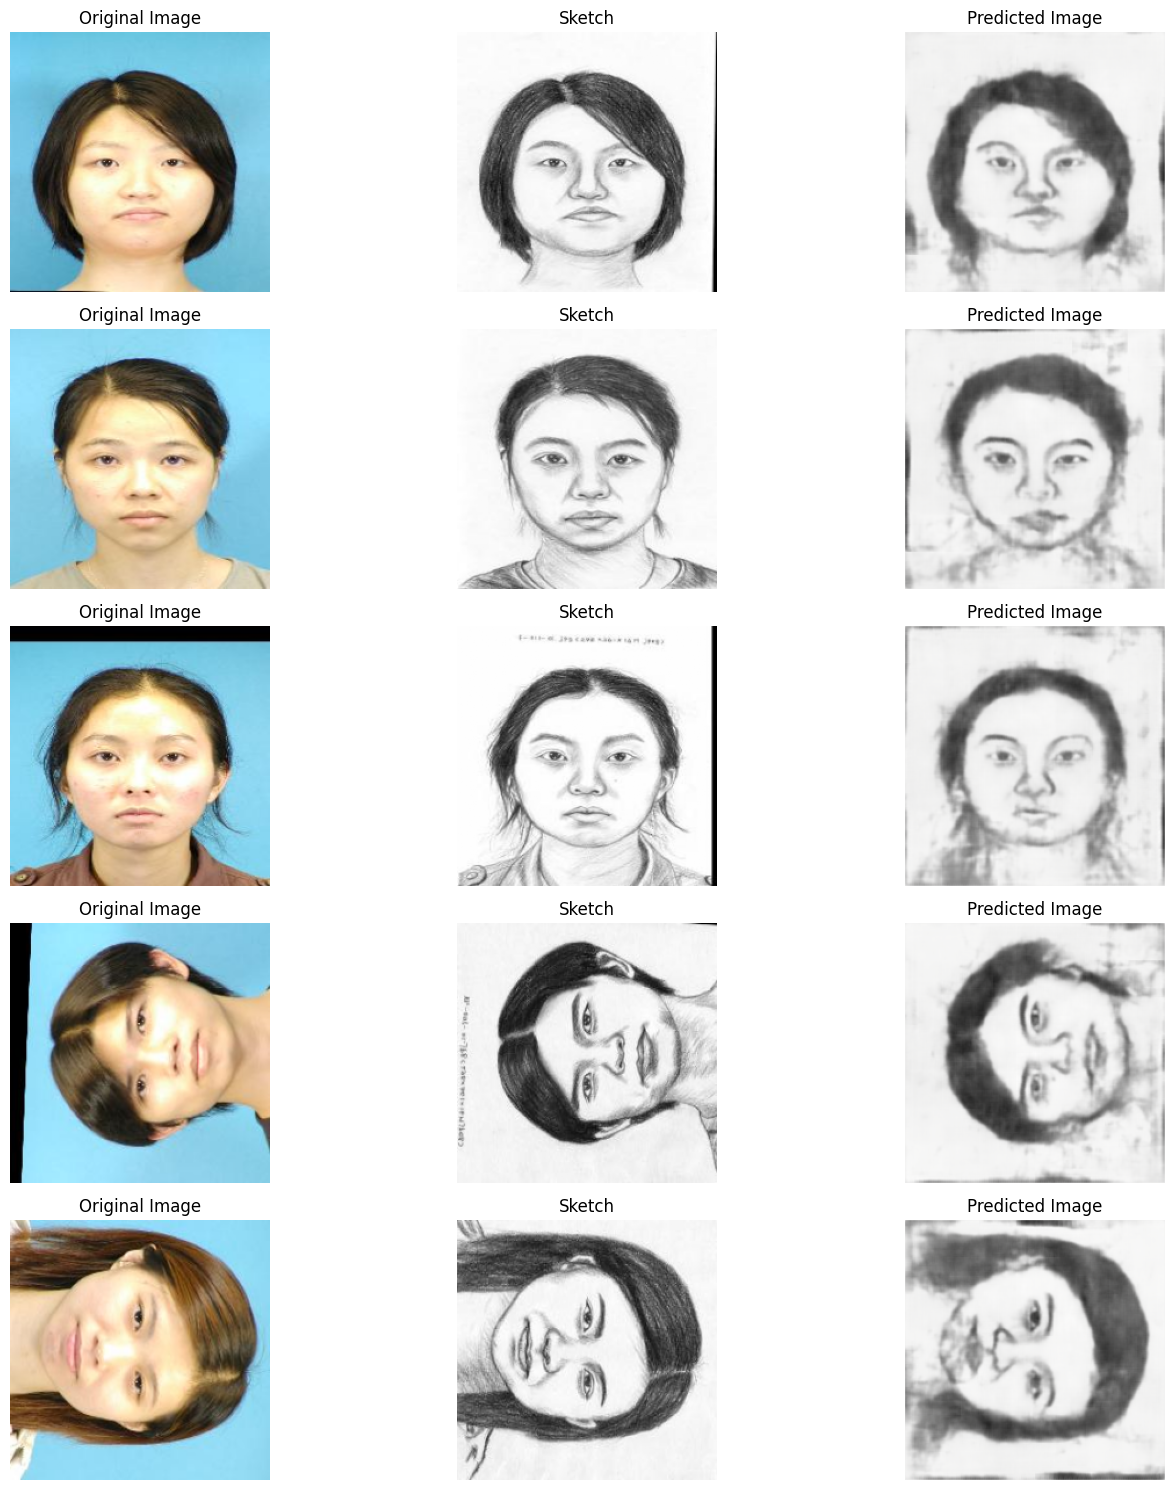

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a function to generate predictions for test_sketch_image
predicted_images = model.predict(test_sketch_image)

num_samples = 5
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 15))

for i in range(num_samples):
    idx = random.randint(0, len(test_sketch_image) - 1)

    # Display original image
    axes[i, 0].imshow(test_image[idx])
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original Image')

    # Display sketch
    axes[i, 1].imshow(test_sketch_image[idx].squeeze(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Sketch')

    # Display predicted image
    axes[i, 2].imshow(predicted_images[idx])
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Predicted Image')

plt.tight_layout()
plt.show()

**VAE**

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Flatten, Lambda, Reshape
# from tensorflow.keras import backend as K
# import tensorflow.keras as keras
# import numpy as np

# IMAGE_SIZE = 224
# latent_dim = 128

# def sampling(args):
#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

# def build_encoder_decoder(encoder_input):
#     # Encoder
#     x = Conv2D(filters=16, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(encoder_input)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.1)(x)

#     x = Conv2D(filters=64, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.1)(x)

#     x = Conv2D(filters=128, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.1)(x)

#     x = Conv2D(filters=256, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.1)(x)

#     x = Conv2D(filters=512, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
#     x = BatchNormalization()(x)
#     encoder_output = LeakyReLU()(x)

#     # Flatten and get z_mean, z_log_var
#     flatten = Flatten()(encoder_output)
#     z_mean = Dense(latent_dim)(flatten)
#     z_log_var = Dense(latent_dim)(flatten)

#     # Sampling layer
#     z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#     # Decoder
#     x = Dense(8 * 8 * 512, activation='relu')(z)
#     x = Reshape((8, 8, 512))(x)

#     x = Conv2DTranspose(filters=512, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
#     x = Dropout(0.1)(x)
#     x = LeakyReLU()(x)

#     x = Conv2DTranspose(filters=512, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
#     x = Dropout(0.1)(x)
#     x = LeakyReLU()(x)

#     x = Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
#     x = Dropout(0.1)(x)
#     x = LeakyReLU()(x)

#     x = Conv2DTranspose(filters=32, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
#     x = Dropout(0.1)(x)
#     x = LeakyReLU()(x)

#     x = Conv2DTranspose(filters=16, kernel_size=(4, 4), strides=2, use_bias=False, kernel_initializer='he_normal')(x)
#     x = Dropout(0.1)(x)
#     x = LeakyReLU()(x)

#     x = Conv2DTranspose(filters=8, kernel_size=(2, 2), strides=(1, 1), padding='valid')(x)
#     x = Dropout(0.1)(x)
#     x = LeakyReLU()(x)

#     decoder_output = Conv2DTranspose(filters=3, kernel_size=(2, 2), strides=(1, 1), padding='valid')(x)

#     return z_mean, z_log_var, decoder_output

# encoder_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# z_mean, z_log_var, decoder_output = build_encoder_decoder(encoder_input)

# # VAE loss
# def vae_loss(encoder_input, decoder_output, z_mean, z_log_var):
#     reconstruction_loss = keras.losses.mean_absolute_error(K.flatten(encoder_input), K.flatten(decoder_output))
#     kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     return K.mean(reconstruction_loss + kl_loss)

# vae_model = Model(encoder_input, decoder_output)
# vae_model.add_loss(vae_loss(encoder_input, decoder_output, z_mean, z_log_var))
# vae_model.compile(optimizer='adam')
# vae_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 111, 111, 16)         768       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 111, 111, 16)         64        ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)  (None, 111, 111, 16)         0         ['batch_normalization_10

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def build_unet(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output
    output = Conv2D(3, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Define input shape based on your IMAGE_SIZE
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
model = build_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
# Assuming you have train_sketch_image and train_image as your training data
# Assuming you have test_sketch_image and test_image as your validation data

# Train the model
history = model.fit(train_sketch_image, train_image,
                    epochs=10,
                    batch_size=32,
                    validation_data=(test_sketch_image, test_image))

# Evaluate the model
loss, accuracy = model.evaluate(test_sketch_image, test_image)

print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/10
38/38 [==============================] - 98s 2s/step - loss: 0.2408 - accuracy: 0.5129 - val_loss: 0.2383 - val_accuracy: 0.5056
Epoch 2/10
38/38 [==============================] - 42s 1s/step - loss: 0.2408 - accuracy: 0.5129 - val_loss: 0.2383 - val_accuracy: 0.5056
Epoch 3/10
38/38 [==============================] - 42s 1s/step - loss: 0.2408 - accuracy: 0.5129 - val_loss: 0.2383 - val_accuracy: 0.5056
Epoch 4/10
38/38 [==============================] - 42s 1s/step - loss: 0.2408 - accuracy: 0.5129 - val_loss: 0.2383 - val_accuracy: 0.5056
Epoch 5/10
38/38 [==============================] - 42s 1s/step - loss: 0.2408 - accuracy: 0.5129 - val_loss: 0.2383 - val_accuracy: 0.5056
Epoch 6/10
 7/38 [====>.........................] - ETA: 30s - loss: 0.2443 - accuracy: 0.5133

KeyboardInterrupt: 

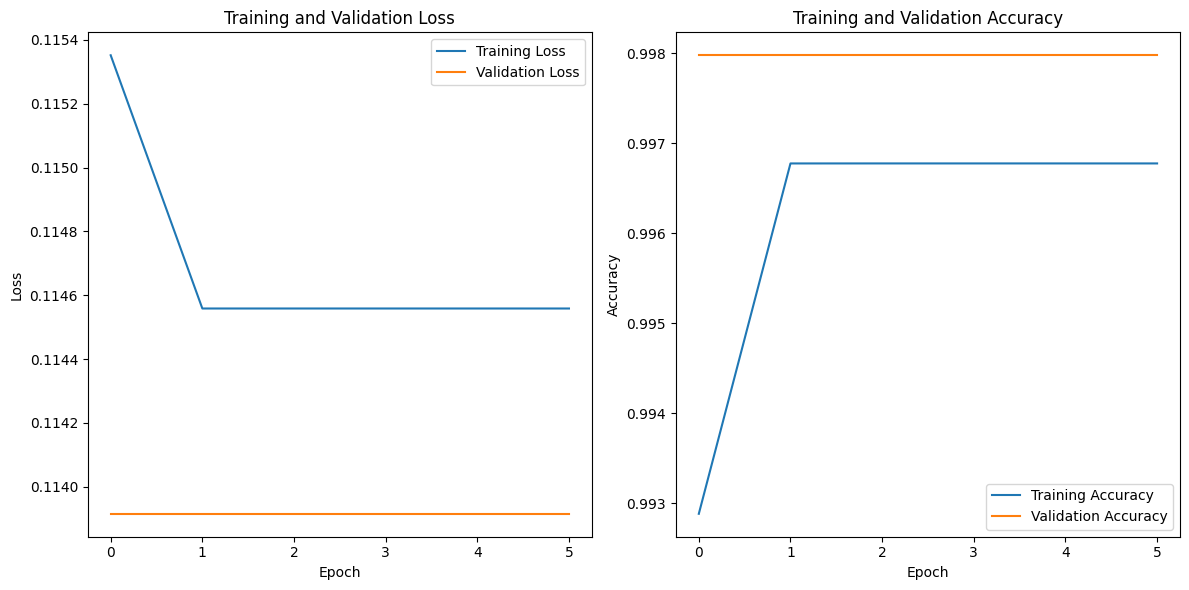

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import random

# Predict on test set
predicted_images = model.predict(test_image)

num_samples = 5
plt.figure(figsize=(15, 15))
for i in range(num_samples):
    idx = random.randint(0, len(test_sketch_image) - 1)

    # Original Image
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(test_image[idx])
    plt.axis('off')
    plt.title('Original Image')

    # Sketch
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(test_sketch_image[idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Sketch')

    # Predicted Image
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(predicted_images[idx])
    plt.axis('off')
    plt.title('Predicted Image')

plt.tight_layout()
plt.show()
